In [123]:
from dolfin import *

# Test for PETSc or Tpetra
if not has_linear_algebra_backend("PETSc") and not has_linear_algebra_backend("Tpetra"):
    info("DOLFIN has not been configured with Trilinos or PETSc. Exiting.")
    exit()

if not has_krylov_solver_preconditioner("amg"):
    info("Sorry, this demo is only available when DOLFIN is compiled with AMG "
         "preconditioner, Hypre or ML.")
    exit()

if has_krylov_solver_method("minres"):
    krylov_method = "minres"
    print("using minres")
elif has_krylov_solver_method("tfqmr"):
    krylov_method = "tfqmr"
    inf0("using tfqmr")
else:
    info("Default linear algebra backend was not compiled with MINRES or TFQMR "
         "Krylov subspace method. Terminating.")
    exit()


using minres


In [108]:
# Load mesh
N = 128
mesh = UnitSquareMesh(N, N)

# Build function space
P2 = VectorElement("Lagrange", mesh.ufl_cell(), 2)
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
TH = P2 * P1
W = FunctionSpace(mesh, TH)

In [109]:
# Boundaries
def right(x, on_boundary): return x[0] > (1.0 - DOLFIN_EPS)
def left(x, on_boundary): return x[0] < DOLFIN_EPS
def top_bottom(x, on_boundary):
    return x[1] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS

# No-slip boundary condition for velocity
noslip = Constant((0.0, 0.0))
bc0 = DirichletBC(W.sub(0), noslip, top_bottom)

# Inflow boundary condition for velocity
inflow = Expression(("-sin(x[1]*pi)", "0.0"), degree=2)
bc1 = DirichletBC(W.sub(0), inflow, right)

# Collect boundary conditions
bcs = [bc0, bc1]


In [110]:
# Define variational problem
(u, p) = TrialFunctions(W)
(v, q) = TestFunctions(W)
f = Constant((0.0, 0.0))
a = inner(grad(u), grad(v))*dx + div(v)*p*dx + q*div(u)*dx
L = inner(f, v)*dx

In [111]:
# Form for use in constructing preconditioner matrix
b = inner(grad(u), grad(v))*dx + p*q*dx


In [112]:
# Assemble system
A, bb = assemble_system(a, L, bcs)

In [113]:
# Assemble preconditioner system
P, btmp = assemble_system(b, L, bcs)

In [126]:
# Create Krylov solver and AMG preconditioner
solver = KrylovSolver(krylov_method, "amg")

# Associate operator (A) and preconditioner matrix (P)
solver.set_operators(A, A)

In [127]:
# Solve
U = Function(W)
solver.solve(U.vector(), bb)

3

In [116]:
# Get sub-functions
u, p = U.split()

# Save solution in VTK format
ufile_pvd = File("velocity.pvd")
ufile_pvd << u
pfile_pvd = File("pressure.pvd")
pfile_pvd << p


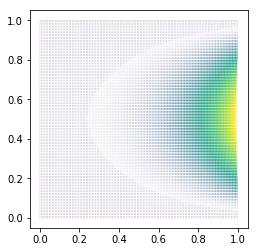

In [117]:
import matplotlib.pyplot as plt
plot(u)
plt.show()